In [92]:
import os
import torch
import time
import copy
import cv2
import numpy as np
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import OneCycleLR, ReduceLROnPlateau
import torch.nn.functional as F
from torchvision.transforms import transforms, InterpolationMode
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
from sklearn.metrics import confusion_matrix
import seaborn as sns

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [3]:
torch.cuda.get_device_name(0)

'NVIDIA GeForce RTX 3060 Laptop GPU'

In [4]:
# Set directory paths
base_path = "D:\data\covid_detection"
data_path = os.path.join(base_path, "dataset")
train_path = os.path.join(data_path, "train")
val_path = os.path.join(data_path, "val")
test_path = os.path.join(data_path, "test")
model_weights_path = "D:\projects\CovidDetection\\trained_model_weights"

In [5]:
class ModelReadyDataCreator:

  def __init__(self, train_path, val_path, test_path, data_path=None, model_weights_path=None, project_path=None,height=224, width=224, batch_size=4):
    self.height = height
    self.width = width
    self.project_path = project_path
    self.data_path = data_path
    self.model_weights_path = model_weights_path
    self.batch_size = batch_size
    self.phases = ['train','val','test']
    self.dirs = {}
    for phase in self.phases:
        if phase == 'train':
            self. dirs[phase] = train_path
        elif phase == 'val' :
            self.dirs[phase] = val_path
        elif phase == 'test':
            self.dirs[phase] = test_path
    

    self.image_datasets = {phase : ImageFolder(self.dirs[phase], transform = self.get_transforms()) for phase in self.phases}

    self.data_loaders = {phase : DataLoader(self.image_datasets[phase], batch_size=self.batch_size, shuffle=True, num_workers=2) for phase in self.phases}

    self.dataset_sizes = {x : len(self.image_datasets[x]) for x in self.phases}

    self.class_names = self.image_datasets[self.phases[0]].classes

    self.num_of_classes = len(self.class_names)

    self.class_to_idx = self.image_datasets[self.phases[0]].class_to_idx

    self.idx_to_class = {val : key for key, val in self.class_to_idx.items()}

  def get_transforms(self, grayscale=False, interpolation_method=InterpolationMode.NEAREST):
    """
    function to return transforms object with all the transformations
    param 0 : resize height
    param 1 : resize width
    param 2 : grayscale image flag
    param 3 : Interpolation method used while resizing
    """

    transformation_list = []

    if grayscale : 
      transformation_list.append(transforms.Grayscale(1))

    transformation_list.append(transforms.Resize((self.height,self.width), interpolation=interpolation_method))
    transformation_list.append(transforms.RandomHorizontalFlip())
    transformation_list.append(transforms.ToTensor())

    if grayscale :
      transformation_list.append(transforms.Normalize(mean=[0.5], std=[0.5]))
    else:
      transformation_list.append(transforms.Normalize(mean=(0.5,0.5,0.5), std=(0.5,0.5,0.5)))
      
    return transforms.Compose(transformation_list)


<H2>Base Architecture </h2>

In [6]:
class BaseConvNet(nn.Module):
    def __init__(self,model_name="baseConvNet", num_classes = 2):
        super().__init__()

        self.model_name = model_name
        self.num_classes = num_classes
        # output size of convolution filter
        # ((w-k+2p)/s) + 1  => w -> image size, k -> kernel, p -> padding, s -> stride
        
        # input_shape = (16, 3, 224, 224)
        self.conv11 = nn.Conv2d(in_channels=3,out_channels=32,kernel_size=3,stride=1,padding=1)
        self.bn11 = nn.BatchNorm2d(num_features=32)
        self.conv12 = nn.Conv2d(in_channels=32, out_channels=32,kernel_size=3,padding=1,stride=1)
        self.bn12 = nn.BatchNorm2d(num_features=32)
        self.conv13 = nn.Conv2d(in_channels=32,out_channels=32,kernel_size=5, stride=2)
        self.bn13 = nn.BatchNorm2d(num_features=32)
        self.dropout1 = nn.Dropout(p=0.4)

        self.conv21 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1)
        self.bn21 = nn.BatchNorm2d(num_features=64)
        self.conv22 = nn.Conv2d(in_channels=64,out_channels=64,kernel_size=3,stride=1,padding=1)
        self.bn22 = nn.BatchNorm2d(num_features=64)
        self.conv23 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=5, stride=2)
        self.bn23 = nn.BatchNorm2d(num_features=64)
        self.dropout2 = nn.Dropout(p=0.4)

        self.flat = nn.Flatten()
        self.fc1 = nn.Linear(64*53*53, 128)
        self.bn31 = nn.BatchNorm1d(num_features=128)
        self.dropout3 = nn.Dropout(0.4)
        self.fc2 = nn.Linear(in_features=128,out_features=2)
        

    # Feed forward function
    def forward(self,image):
        bs, c, h, w = image.size()
        output = F.relu(self.bn11(self.conv11(image)))  # shape = (bs, 32, 224, 224)
        output = F.relu(self.bn12(self.conv12(output))) # shape = (bs, 32, 224, 224)
        output = F.relu(self.bn13(self.conv13(output))) # shape = (bs, 32, 110, 110)
        output = self.dropout1(output) # shape = (bs, 32, 110, 110)

        output = F.relu(self.bn21(self.conv21(output))) # shape = (bs, 64, 110, 110)
        output = F.relu(self.bn22(self.conv22(output))) # shape = (16, 64, 110, 110)
        output = F.relu(self.bn23(self.conv23(output))) # shape = (16, 64, 53, 53)
        output = self.dropout2(output) # shape = (16, 64, 53, 53)

        # output = self.flat(output)
        # or we can directly use output = nn.Flatten()(output)
        output = output.view(bs,-1) # shape = (bs, 179776)
        output = self.bn31(self.fc1(output)) # shape (bs, 128)
        output = self.dropout3(output) # shape (bs, 128)
        output = self.fc2(output) # shape (bs, 2)
        return output

In [7]:
model_ready_data_creator = ModelReadyDataCreator(train_path, val_path, test_path, data_path, model_weights_path)
data_loader = model_ready_data_creator.data_loaders
dataset_sizes = model_ready_data_creator.dataset_sizes

In [9]:
model = BaseConvNet(num_classes=2).to(device)

In [10]:
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=0.001)
loss_function = nn.CrossEntropyLoss()

In [23]:
since = time.time()
best_model_weights = copy.deepcopy(model.state_dict())
best_acc = 0.0
num_epochs = 10
for epoch in range(num_epochs):
    print('Epoch {}/{}'.format(epoch,num_epochs))
    # Training a model
    model.train()
    
    current_train_loss = 0.0
    currect_train_corrects = 0

    with torch.set_grad_enabled(True):

        for inputs, labels in data_loader['train']:
            
            if torch.cuda.is_available():
                inputs = inputs.to(device)
                labels = labels.to(device)

            outputs = model(inputs)

            loss = loss_function(outputs,labels)

            max_element, preds = torch.max(outputs,1)

            optimizer.zero_grad()

            loss.backward()

            optimizer.step()

            current_train_loss = loss.cpu().data * inputs.size(0)

            currect_train_corrects += int(torch.sum(preds == labels.data))

    train_epoch_loss = current_train_loss/dataset_sizes['train']
    train_epoch_accuracy = currect_train_corrects/dataset_sizes['train']

    print('Train loss : {:.4f} Accuracy : {:.4f}'.format(train_epoch_loss, train_epoch_accuracy))

    # Evaluating on testing val data
    model.eval()

    current_eval_loss = 0.0
    current_eval_corrects = 0

    with torch.no_grad():

        for inputs, labels in data_loader['val']:

            if torch.cuda.is_available():
                inputs = inputs.to(device)
                labels = labels.to(device)

                outputs = model(inputs)
                _,preds = torch.max(outputs,1)
                loss = loss_function(outputs, labels)

                current_eval_loss = loss.cpu().data * inputs.size(0)
                current_eval_corrects += int(torch.sum(preds == labels.data))

    val_epoch_loss = current_eval_loss/dataset_sizes['val']
    val_epoch_accuracy = current_eval_corrects/dataset_sizes['val']

    print('Eval loss : {:.4f} Accuracy : {:.4f}'.format(val_epoch_loss,val_epoch_accuracy))
    
    if val_epoch_accuracy > best_acc:
        best_model_weights = copy.deepcopy(model.state_dict())
        best_acc = val_epoch_accuracy
        print(f'Saving weights for {epoch} epoch')
        checkpoint_name = f"weight_{epoch}.pt"
        PATH = os.path.join(current_model_weight_path, checkpoint_name)
        torch.save({'state_dict': model.state_dict(),
                    'optimizer_state_dict' : optimizer.state_dict(),
                    'epoch' : epoch
                    }, 
                    PATH)

end_time = time.time() - since
print('Training complete in {:.0f}m {:.0f}s'.format(end_time // 60, end_time % 60))
print('Best validation Accuracy: {:4f}'.format(best_acc))

Epoch 0/10
Train loss : 0.0006 Accuracy : 0.7500
Eval loss : 0.0296 Accuracy : 0.8500
Saving weights for 0 epoch
Epoch 1/10
Train loss : 0.0051 Accuracy : 0.7276
Eval loss : 0.0064 Accuracy : 0.9250
Saving weights for 1 epoch
Epoch 2/10
Train loss : 0.0007 Accuracy : 0.7788
Eval loss : 0.0111 Accuracy : 0.9000
Epoch 3/10
Train loss : 0.0066 Accuracy : 0.6987
Eval loss : 0.0224 Accuracy : 0.8250
Epoch 4/10
Train loss : 0.0029 Accuracy : 0.6987
Eval loss : 0.0037 Accuracy : 0.9250
Epoch 5/10
Train loss : 0.0022 Accuracy : 0.7019
Eval loss : 0.0096 Accuracy : 0.8250
Epoch 6/10
Train loss : 0.0010 Accuracy : 0.7019
Eval loss : 0.0164 Accuracy : 0.8500
Epoch 7/10
Train loss : 0.0016 Accuracy : 0.7019
Eval loss : 0.0136 Accuracy : 0.9250
Epoch 8/10
Train loss : 0.0054 Accuracy : 0.7115
Eval loss : 0.0049 Accuracy : 0.9000
Epoch 9/10
Train loss : 0.0061 Accuracy : 0.7340
Eval loss : 0.0081 Accuracy : 0.9000
Training complete in 2m 17s
Best validation Accuracy: 0.925000


In [7]:
def train_loop(model, data_loader, optimizer, scheduler, loss_function, device=torch.device("cuda")):
  """
  function to train model
  :param model : model to train
  :data_loader : data_loader of training phase
  :scheduler : scheduler
  :loss_function : loss function
  :device : device on which we need to train
  :return: tuple(running loss, current currect prediction)
  """
  print('Train mode')
  # set training mode : It changed the behaviour of some layers like batch normalization use batch data not saved statistics(it happens in val & test phase), droupout is enabled
  model.train()
  
  current_loss = 0.0
  current_corrects = 0
  
  # The torch.set_grad_enabled line of code makes sure to clear the intermediate values for evaluation, which are needed to backpropagate during training
  with torch.set_grad_enabled(True):
    
    # print("Iterating through data")
    for inputs, labels in data_loader :
      # moving the inputs and labels to device passed in function
      inputs = inputs.to(device)
      labels = labels.to(device)

      outputs = model(inputs)
      max_element,preds = torch.max(outputs,1)
      loss = loss_function(outputs, labels)

      # setting zero to all gradients before gradient calculation/backpropogation
      optimizer.zero_grad() 

      # Do backpropagation/calculate gradient
      # Backward pass: compute gradient of the loss with respect to model
      loss.backward()

      # update weights/parameters
      optimizer.step()

      if scheduler:
        # If you don’t call it, the learning rate won’t be changed and stays at the initial value.
        # should call scheduler.step() after the optimizer.step() 
        scheduler.step()

      # It's because the loss given by CrossEntropy or other loss functions is divided by the number of elements i.e. the reduction parameter is mean by default. 
      # torch.nn.CrossEntropyLoss(weight=None, size_average=None, ignore_index=-100, reduce=None, reduction='mean')
      # Hence, loss.item() contains the loss of entire mini-batch, but divided by the batch size. That's why loss.item() is multiplied with batch size, given by inputs.size(0), while calculating running_loss.
      # here we'll get mean of loss of entire batch using loss.item() that's why we are multiplying it with batch_ size to get current loss.
      current_loss = loss.item() * inputs.size(0)
      current_corrects += torch.sum(preds == labels.data)

  return current_loss, current_corrects


In [8]:
def eval_loop(model, data_loader, loss_function, device=torch.device("cuda")):
  """
  function to validate model
  :param model : model to train
  :data_loader : data_loader of training phase
  :scheduler : scheduler
  :loss_function : loss function
  :device : device on which we need to train
  :return: tuple(running loss, current currect prediction)
  """
  print('Validation mode')
  # dropout is disabled and so is replaced with a no op. Similarly, bn should use saved statistics instead of batch data 
  model.eval()

  current_loss = 0.0
  current_corrects = 0

  # impacts the autograd engine and deactivate it. It will reduce memory usage and speed up computations but you won’t be able to backprop (which you don’t want in an eval script).
  # it is same as with torch.set_grad_enabled(False):
  with torch.no_grad():

    # print("Iterating through data")
    for inputs, labels in data_loader :

      # moving the inputs and labels to device passed in function
      inputs = inputs.to(device)
      labels = labels.to(device)

      outputs = model(inputs)
      _,preds = torch.max(outputs,1)
      loss = loss_function(outputs, labels)

      current_loss = loss.item() * inputs.size(0)
      current_corrects += torch.sum(preds == labels.data)
    
  return current_loss, current_corrects
  

In [9]:
def training_load_checkpoint(checkpoint_path, model, optimizer):
  """
  function to load checkpoint
  :param checkpoint_path: checkpoint path
  :param model: model 
  :param optimizer: optimizer
  """
  checkpoint = torch.load(checkpoint_path)
  model.load_state_dict(checkpoint['state_dict'])
  optimizer.load_state_dict(checkpoint['optimizer'])
  return model, optimizer, checkpoint['epoch']+1

In [10]:
def training(model, loss_function, optimizer, scheduler, model_ready_data_creator, another_scheduler = None, num_epochs = 50, start_epoch = 1):

  since = time.time()
  data_loader = model_ready_data_creator.data_loaders
  dataset_sizes = model_ready_data_creator.dataset_sizes
  model_weights_path = model_ready_data_creator.model_weights_path
  idx_to_class = model_ready_data_creator.idx_to_class
  class_to_idx = model_ready_data_creator.class_to_idx

  current_model_weight_path = os.path.join(model_weights_path, model.model_name)
  if not os.path.exists(current_model_weight_path):
    os.mkdir(current_model_weight_path)

  train_loss_values = []
  val_loss_values = []

  train_accuracy_values = []
  val_accuracy_values = []

  best_model_weights = copy.deepcopy(model.state_dict())
  best_acc = 0.0

  for epoch in range(start_epoch, num_epochs+1) : 
    print('Epoch {}/{}'.format(epoch,num_epochs))
    print('-'*150)

    train_loss, train_corrects = train_loop(model, data_loader['train'], optimizer, scheduler, loss_function, device)

    # here we are taking running loss and divide it by whole dataset_size to get the average/mean loss
    train_epoch_loss = train_loss/dataset_sizes['train']
    # calculating accuracy by dividing total_corrects/dataset_size
    train_epoch_accuracy = train_corrects.double()/dataset_sizes['train']
    print('Train Loss: {:.4f} Accuracy : {:.4f}'.format(train_epoch_loss, train_epoch_accuracy))
    print('-'*50)

    train_loss_values.append(train_epoch_loss)
    train_accuracy_values.append(train_epoch_accuracy)

    validation_loss, validation_corrects = eval_loop(model, data_loader['val'], loss_function, device)
    validation_epoch_loss = validation_loss/dataset_sizes['val']
    validation_epoch_accuracy = validation_corrects.double()/dataset_sizes['val']
    print('Validation Loss : {:.4f} Accuracy : {:.4f}'.format(validation_epoch_loss, validation_epoch_accuracy))

    val_loss_values.append(validation_epoch_loss)
    val_accuracy_values.append(validation_epoch_accuracy)
    
    if another_scheduler:
      another_scheduler.step(validation_epoch_loss)

    if validation_epoch_accuracy > best_acc : 
        best_model_weights = copy.deepcopy(model.state_dict())
        best_acc = validation_epoch_accuracy
        print(f'Saving weights for {epoch} epoch')
        checkpoint_name = f"weight_{epoch}.tar"
        PATH = os.path.join(current_model_weight_path, checkpoint_name)
        torch.save({'state_dict': model.state_dict(),
                    'class_to_idx': class_to_idx
                    }, 
                    PATH)
        
    print()

  checkpoint_name = f"best_weight.tar"
  PATH = os.path.join(current_model_weight_path, checkpoint_name)
  torch.save({'state_dict': best_model_weights,   
              'class_to_idx': class_to_idx
              }, 
              PATH)
  
  time_since = time.time() - since
  print('Training complete in {:.0f}m {:.0f}s'.format(time_since // 60, time_since % 60))
  print('Best validation Accuracy: {:4f}'.format(best_acc))
  # Now we'll load in the best model weights and return it
  model.load_state_dict(best_model_weights)
  return model, train_loss_values, train_accuracy_values, val_loss_values, val_accuracy_values

In [11]:
model_ready_data_creator = ModelReadyDataCreator(train_path, val_path, test_path, data_path, model_weights_path, batch_size=32)
model = BaseConvNet(model_name="baseConvNet",num_classes=model_ready_data_creator.num_of_classes)
model = model.to(device)
loss_function = nn.CrossEntropyLoss()

epochs = 20
lr = 1e-3
optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=0.1)
num_steps = len(model_ready_data_creator.data_loaders['train'])
start_epoch = 1

# if we want to resume training then set below flag True and provide checkpoint_name and path
resume_training = False
if resume_training:
  model_weights_path = model_ready_data_creator.model_weights_path
  #change here
  current_model_weight_path = os.path.join(model_weights_path, "baseConvNet")
  #change here
  checkpoint_name = f"weight_5.pt"
  checkpoint_path = os.path.join(current_model_weight_path, checkpoint_name)

  model, optimizer, start_epoch = training_load_checkpoint(checkpoint_path, model, optimizer)

one_cycle_scheduler = OneCycleLR(optimizer, max_lr=lr, epochs=epochs, steps_per_epoch=num_steps)
reduce_lr_scheduler = ReduceLROnPlateau(optimizer,verbose=True,factor=0.1)

In [12]:
model, train_loss_values, train_accuracy_values, val_loss_values, val_accuracy_values = training(model, loss_function, optimizer, one_cycle_scheduler, model_ready_data_creator, another_scheduler = reduce_lr_scheduler, num_epochs = epochs, start_epoch = start_epoch)

Epoch 1/20
------------------------------------------------------------------------------------------------------------------------------------------------------
Train mode
Train Loss: 0.0042 Accuracy : 0.8942
--------------------------------------------------
Validation mode
Validation Loss : 0.3131 Accuracy : 0.5000
Saving weights for 1 epoch

Epoch 2/20
------------------------------------------------------------------------------------------------------------------------------------------------------
Train mode
Train Loss: 0.0172 Accuracy : 0.9808
--------------------------------------------------
Validation mode
Validation Loss : 0.3561 Accuracy : 0.5000

Epoch 3/20
------------------------------------------------------------------------------------------------------------------------------------------------------
Train mode
Train Loss: 0.0102 Accuracy : 0.9776
--------------------------------------------------
Validation mode
Validation Loss : 0.2668 Accuracy : 0.5000

Epoch 4/20

<h1> Testing </h1>

In [25]:
def load_model(model, model_weights) :
  
  model.load_state_dict(model_weights)
  for parameter in model.parameters():
      parameter.requires_grad = False

  model.eval()
  return model


In [87]:
def process_image(img, height, width):

  img = np.resize(img,(height,width,3))
  img = np.array(img)/255
  mean = np.array([0.5, 0.5, 0.5]) #provided mean
  std = np.array([0.5, 0.5, 0.5]) #provided std
  img = (img - mean)/std

  # Move color channels to first dimension as expected by PyTorch
  img = img.transpose((2, 0, 1))

  return img

In [27]:
def show_image(image, title = 'Document'):
  
  image = image.transpose((1,2,0))
  mean = np.array([0.5, 0.5, 0.5]) #provided mean
  std = np.array([0.5, 0.5, 0.5]) #provided std
  image = std * image +  mean

  plt.title(title)
  plt.imshow(image)


In [94]:
def predict(model, image, idx_to_class, height, width):
  #process input image
  img = process_image(image, height, width)

  # change numpy array to PyTorch tensor
  img = torch.from_numpy(img).type(torch.FloatTensor)

  # Add batch of size 1 to image i.e we have (channel, widht,height) and we convert it to (batch_size, channel, width , height) i.e (1, channel, width, height)
  img.unsqueeze_(0)

  outputs = model(img)
  _, preds = torch.max(outputs, 1)

  class_id = preds.item()
  class_name = idx_to_class[class_id]

  return class_name

In [35]:
def calculate_accuracy(model, data_loader, dataset_sizes):

  model.to(device='cuda')
  
  original_classes = []
  predicted_classes = []
  current_corrects = 0
  with torch.no_grad():

    for inputs, labels in data_loader:
      inputs = inputs.to(device)
      labels = labels.to(device)

      outputs = model(inputs)
      _, preds = torch.max(outputs, 1)

      original_classes.extend(labels.tolist())
      predicted_classes.extend(preds.tolist())
      current_corrects += torch.sum(preds == labels.data)

  accuracy = current_corrects/dataset_sizes["test"]

  return accuracy, original_classes, predicted_classes

In [42]:
# This function plots the confusion matrices given y_i, y_i_hat.
def plot_confusion_matrix(test_y, predict_y, labels):
    C = confusion_matrix(test_y, predict_y)
    # C = 9,9 matrix, each cell (i,j) represents number of points of class i are predicted class j
    
    A =(((C.T)/(C.sum(axis=1))).T)
    #divid each element of the confusion matrix with the sum of elements in that column
    
    # C = [[1, 2],
    #     [3, 4        
    # C.T = [[1, 3],
    #        [2, 4]]
    # C.sum(axis = 1)  axis=0 corresonds to columns and axis=1 corresponds to rows in two diamensional array
    # C.sum(axix =1) = [[3, 7]]
    # ((C.T)/(C.sum(axis=1))) = [[1/3, 3/7]
    #                           [2/3, 4/7]]

    # ((C.T)/(C.sum(axis=1))).T = [[1/3, 2/3]
    #                           [3/7, 4/7]]
    # sum of row elements = 1
    
    B =(C/C.sum(axis=0))
    #divid each element of the confusion matrix with the sum of elements in that row
    # C = [[1, 2],
    #     [3, 4]]
    # C.sum(axis = 0)  axis=0 corresonds to columns and axis=1 corresponds to rows in two diamensional array
    # C.sum(axix =0) = [[4, 6]]
    # (C/C.sum(axis=0)) = [[1/4, 2/6],
    #                      [3/4, 4/6]] 
    
    # representing A in heatmap format
    print("-"*20, "Confusion matrix", "-"*20)
    plt.figure(figsize=(20,7))
    sns.heatmap(C, annot=True, cmap="YlGnBu", fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.show()

    print("-"*20, "Precision matrix (Columm Sum=1)", "-"*20)
    plt.figure(figsize=(20,7))
    sns.heatmap(B, annot=True, cmap="YlGnBu", fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.show()
    
    # representing B in heatmap format
    print("-"*20, "Recall matrix (Row sum=1)", "-"*20)
    plt.figure(figsize=(20,7))
    sns.heatmap(A, annot=True, cmap="YlGnBu", fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.show()

In [30]:
# setting path for testing
model_ready_data_creator = ModelReadyDataCreator(train_path, val_path, test_path, data_path, model_weights_path)
model_weights_path = model_ready_data_creator.model_weights_path
current_model_weight_path = os.path.join(model_weights_path, "baseConvNet")
checkpoint_name = f"best_weight.tar"
check_point_path = os.path.join(current_model_weight_path, checkpoint_name)

In [33]:
check_point = torch.load(check_point_path)
model = BaseConvNet(num_classes=model_ready_data_creator.num_of_classes).to(device)
model = load_model(model, check_point["state_dict"])
class_to_idx = model_ready_data_creator.class_to_idx
idx_to_class = model_ready_data_creator.idx_to_class

In [37]:
data_loader = model_ready_data_creator.data_loaders
dataset_sizes = model_ready_data_creator.dataset_sizes
accuracy, original_classes, predicted_classes = calculate_accuracy(model, data_loader['test'], dataset_sizes)

In [40]:
accuracy.item()

1.0

-------------------- Confusion matrix --------------------


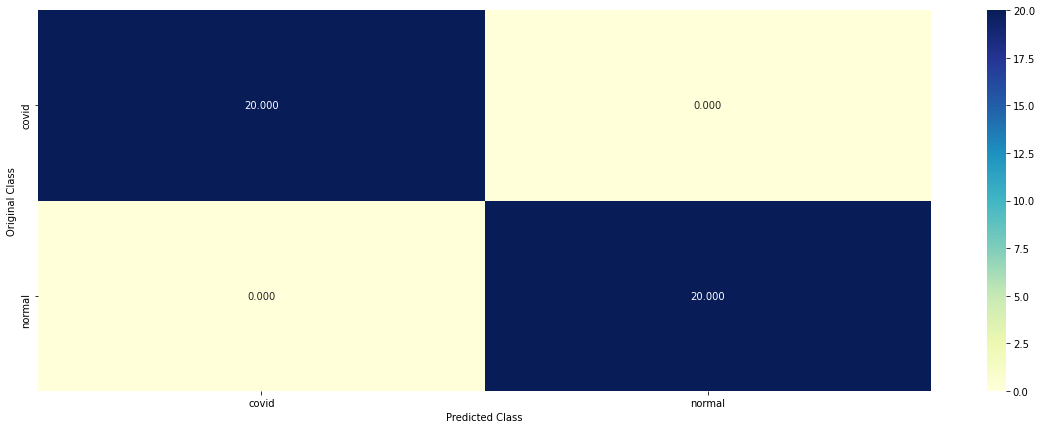

-------------------- Precision matrix (Columm Sum=1) --------------------


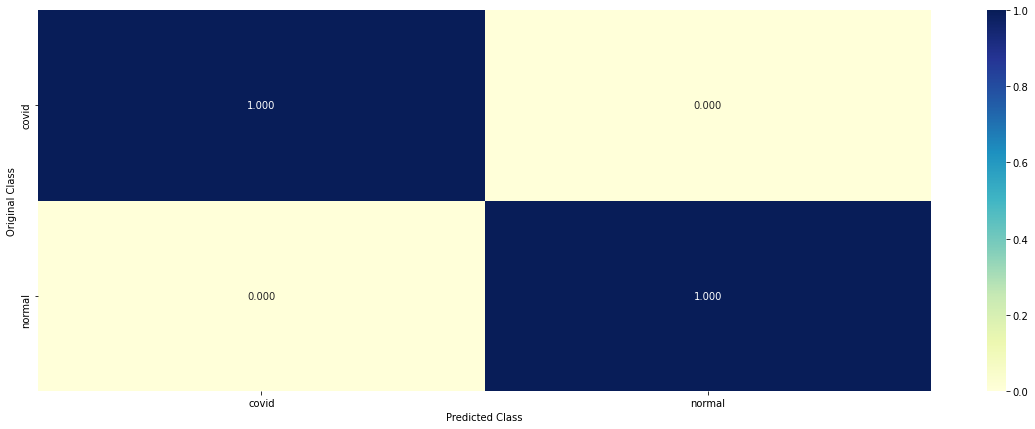

-------------------- Recall matrix (Row sum=1) --------------------


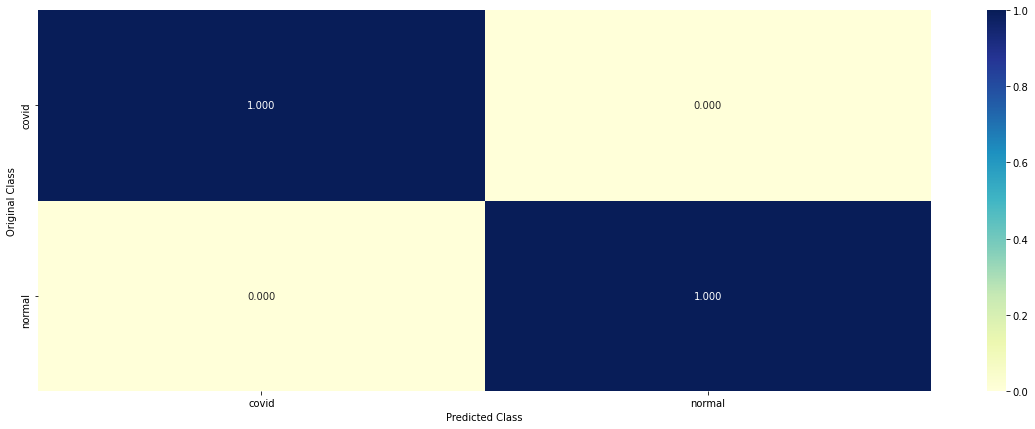

In [51]:
class_names = model_ready_data_creator.class_names
plot_confusion_matrix(original_classes, predicted_classes, class_names)

<h1> Prediction on single Image </h1>

In [93]:
# Loading model on CPU --> To load model on CPU we just need to pass map_location = torch.device("cpu") in torch.load()
cpu_device = torch.device("cpu")
check_point = torch.load(check_point_path, map_location = torch.device(cpu_device))
model = BaseConvNet(num_classes=model_ready_data_creator.num_of_classes)
model = load_model(model, check_point["state_dict"])
class_to_idx = model_ready_data_creator.class_to_idx
idx_to_class = model_ready_data_creator.idx_to_class

In [96]:
image_path = os.path.join(test_path,"covid", "1-s2.0-S1684118220300682-main.pdf-002-a1.png")
image = cv2.imread(image_path)

In [97]:
prediction = predict(model, image, idx_to_class, model_ready_data_creator.height, model_ready_data_creator.width)

In [98]:
prediction

'covid'